# Android Tap and Sensor Fusion

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from collections import OrderedDict as od
from numpy import mean, var
from scipy.stats import skew, kurtosis
import json
import matplotlib.pyplot as plt
import glob
import os
import ast
import seaborn as sns, numpy as np
%matplotlib inline
import matplotlib.dates as dates
import statsmodels.api as sm
import os, sys, inspect
sys.path.insert(0,'../Scripts/madgwickahrs.py')
from madgwickahrs import *
from quaternion import *
import json

/usr/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
import madgwickahrs, quaternion

In [3]:
ls ../Data/SensorInfo/201711*

../Data/SensorInfo/201711091951  ../Data/SensorInfo/201711161638
../Data/SensorInfo/201711092033  ../Data/SensorInfo/201711182141


##### Sensor Data Parser

In [4]:
def parseSensorData(filename):
    x=pd.read_csv(filename)
    x.columns=x.columns.map(lambda x:str(x).strip())
    sensorNameDict=dict(zip(set(x.sensorName),[str(sensor).strip().partition(' ')[2] for sensor in (set(x.sensorName))]))
    x['sensorName']=x['sensorName'].replace(sensorNameDict)
    data_Accelerometer=x.loc[x.sensorName=="Accelerometer"].reset_index().drop(['index','sensorName'],axis=1)
    data_Gyroscope=x.loc[x.sensorName=="Gyroscope"].reset_index().drop(['index','sensorName'],axis=1)
    data_Magnetometer=x.loc[x.sensorName=="Magnetometer"].reset_index().drop(['index','sensorName'],axis=1)
    acc=data_Accelerometer[['timestamp','lastAccelerometerValues[0]','lastAccelerometerValues[1]','lastAccelerometerValues[2]']].groupby('timestamp').mean()
    gyr=data_Gyroscope[['timestamp','lastGyroscopeValues[0]','lastGyroscopeValues[1]','lastGyroscopeValues[2]']].groupby('timestamp').mean()
    mag=data_Magnetometer[['timestamp','lastMagnetometerValues[0]','lastMagnetometerValues[1]','lastMagnetometerValues[2]']].groupby('timestamp').mean()
    return acc,gyr,mag

~

In [5]:
ls ../Data/TapInfo/ml16*

../Data/TapInfo/ml16-141402-201711091951-export.json
../Data/TapInfo/ml16-141402-201711092033-export.json
../Data/TapInfo/ml16-141402-201711161638-export.json
../Data/TapInfo/ml16-141402-201711182141-export.json


##### Tap Data Parser

In [6]:
def parseTapData(filename):
    tapInfo=pd.read_json(filename)
    cols=['eventTime', 'pointerCount', 'source', 'buttonState', 'actionButton', 'id0', 'historySize', 'toolType0', 'flags', 'deviceId', 'downTime', 'action', 'y0', 'x0', 'metaState', 'edgeFlags']
    df=pd.DataFrame(columns=cols)
    for btnID, btn in tapInfo.btnID.iteritems():
        sample=ast.literal_eval(str(btn).replace('u\'','\''))
        for timestamp in sample.keys():
            event=ast.literal_eval(str(sample[timestamp]))
            if type(event) is dict:
                idx = event.keys()[0]
                row=str(event[idx]) 
            else:
                idx=0
                row=str(event[0])
            t=row.replace('MotionEvent ','').replace('[','').replace(']','').replace('=','\':\'').replace(', ','\', \'').replace('\'{ ','{\'').replace(' }\'','\'}')
            dt=ast.literal_eval(t)
            dx=pd.DataFrame.from_records([dt],index=[0])
            if '2' in dx.columns:
                dx=pd.DataFrame.from_records([dx['2'][0]],index=[0]) 
            dx['action']=dx['action'][0][7:]
            dx['id0']=idx
            dx['actionButton']=int(btnID)
            dx['buttonState']=long(timestamp)
            dx['downTime']=long(dx['downTime'])
            dx['eventTime']=long(dx['eventTime'])
            df=pd.concat([df,dx],axis=0)
    df=df.sort('eventTime').reset_index().drop(['index','metaState','deviceId','edgeFlags','flags','historySize','pointerCount','source','toolType0','id0','x0','y0'],axis=1)
    df=df[df['action']=='UP']
    return df

~

### Load all data

In [7]:
accData=od()
gyrData=od()
magData=od()
tapData=od()

In [8]:
for filename in glob.glob('../Data/TapInfo/ml16*'):
    key=filename.split('ml16-141402-')[-1].split('-')[0]
    print(key)
    tapData[key]=parseTapData(filename)

201711091951


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:27: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


201711092033
201711182141
201711161638


In [9]:
for filename in glob.glob('../Data/SensorInfo/201711*'):
    key=filename.split('/')[-1]
    print(key)
    accData[key],gyrData[key],magData[key]=parseSensorData(filename)

201711092033
201711091951
201711161638
201711182141


### AHRS Filter

In [10]:
from IPython.display import clear_output
import csv

In [11]:
def getSensors(a, g, m):
    sensors=pd.DataFrame()
    sensors=pd.concat([a,g,m],axis=1)
    sensors=pd.DataFrame(sensors,index=range(sensors.index[0],sensors.index[-1])).fillna(method='bfill').reset_index()
    return sensors

In [12]:
%time
sensorData=od()
for key in accData.keys():
    sensorData[key]=getSensors(accData[key],gyrData[key],magData[key])

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 4.05 µs


In [13]:
%store sensorData
%store tapData

Stored 'sensorData' (OrderedDict)
Stored 'tapData' (OrderedDict)


In [14]:
def extractQuats(key,sensors):
   # quat=pd.DataFrame()
    qt = MadgwickAHRS(sampleperiod=0.001)
    quat_old=0
    path='../Data/Quaternion/'+key+'.csv'
    with open(path, "wb") as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
        writer.writerow(['idx','q0','q1','q2','q3'])
        for idx,row in sensors.iterrows():
            acc = np.array([row['lastAccelerometerValues[0]'], row['lastAccelerometerValues[1]'], row['lastAccelerometerValues[2]']])
            gyr = np.array([row['lastGyroscopeValues[0]'], row['lastGyroscopeValues[1]'], row['lastGyroscopeValues[2]']])
            mag = np.array([row['lastMagnetometerValues[0]'], row['lastMagnetometerValues[1]'], row['lastMagnetometerValues[2]']])
            gyr_rad = gyr * (np.pi/180)
            qt.update(gyr_rad,acc,mag)
            #quat=quat.append(pd.DataFrame([qt.quaternion.q]))
            line=[idx,qt.quaternion.q[0],qt.quaternion.q[1],qt.quaternion.q[2],qt.quaternion.q[3]]
            writer.writerow(line)
            clear_output()
            print str(100.0*idx/sensors.shape[0])+'% completed'

In [ ]:
%time
for key in accData.keys():
    s=getSensors(accData[key],gyrData[key],magData[key])
    extractQuats(key,s)

In [24]:
def extractEulers(key,sensors):
    qt = MadgwickAHRS(sampleperiod=0.001)
    path='../Data/Euler/'+key+'.csv'
    with open(path, "wb") as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
        writer.writerow(['idx','roll','pitch','yaw'])
        for idx,row in sensors.iterrows():
            acc = np.array([row['lastAccelerometerValues[0]'], row['lastAccelerometerValues[1]'], row['lastAccelerometerValues[2]']])
            gyr = np.array([row['lastGyroscopeValues[0]'], row['lastGyroscopeValues[1]'], row['lastGyroscopeValues[2]']])
            mag = np.array([row['lastMagnetometerValues[0]'], row['lastMagnetometerValues[1]'], row['lastMagnetometerValues[2]']])
            gyr_rad = gyr * (np.pi/180)
            qt.update(gyr_rad,acc,mag)
            e=list(qt.quaternion.to_euler_angles())
            line=[idx,e[0],e[1],e[2]]
            writer.writerow(line)
            clear_output()
            print str(100.0*idx/sensors.shape[0])+'% completed'

In [ ]:
%time
for key in accData.keys():
    s=getSensors(accData[key],gyrData[key],magData[key])
    extractEulers(key,s)

26.7681678656% completed


In [15]:
plt.show()

### Data Integration & Feature Extraction

In [16]:
data=od()

In [17]:
def getData(acc,gyr,mag,row):
        prior=50
        span=30
        win=row['eventTime']-row['downTime']
        a1=acc.query('timestamp>='+str(row['downTime']-prior)+'and timestamp<='+str(row['downTime']+win//2))
        g1=gyr.query('timestamp>='+str(row['downTime']-prior)+'and timestamp<='+str(row['downTime']+win//2))
        m1=mag.query('timestamp>='+str(row['downTime']-prior)+'and timestamp<='+str(row['downTime']+win//2))
        a2=acc.query('timestamp>='+str(row['downTime']+win//2)+'and timestamp<='+str(row['downTime']+span))
        g2=gyr.query('timestamp>='+str(row['downTime']+win//2)+'and timestamp<='+str(row['downTime']+span))
        m2=mag.query('timestamp>='+str(row['downTime']+win//2)+'and timestamp<='+str(row['downTime']+span))

        d=pd.concat([
            pd.DataFrame([row['actionButton']],columns=['target']).T,
            a1.apply(mean).rename(lambda x:x+'_mean_D').T,
            a1.apply(var).rename(lambda x:x+'_var_D'),
            a1.apply(skew).rename(lambda x:x+'_skew_D'),
            a1.apply(kurtosis).rename(lambda x:x+'_kurtosis_D'),
            g1.apply(mean).rename(lambda x:x+'_mean_D'),
            g1.apply(var).rename(lambda x:x+'_var_D'),
            g1.apply(skew).rename(lambda x:x+'_skew_D'),
            g1.apply(kurtosis).rename(lambda x:x+'_kurtosis_D'),
            m1.apply(mean).rename(lambda x:x+'_mean_D'),
            m1.apply(var).rename(lambda x:x+'_var_D'),
            m1.apply(skew).rename(lambda x:x+'_skew_D'),
            m1.apply(kurtosis).rename(lambda x:x+'_kurtosis_D'),
            a2.apply(mean).rename(lambda x:x+'_mean_U').T,
            a2.apply(var).rename(lambda x:x+'_var_U'),
            a2.apply(skew).rename(lambda x:x+'_skew_U'),
            a2.apply(kurtosis).rename(lambda x:x+'_kurtosis_U'),
            g2.apply(mean).rename(lambda x:x+'_mean_U'),
            g2.apply(var).rename(lambda x:x+'_var_U'),
            g2.apply(skew).rename(lambda x:x+'_skew_U'),
            g2.apply(kurtosis).rename(lambda x:x+'_kurtosis_U'),
            m2.apply(mean).rename(lambda x:x+'_mean_U'),
            m2.apply(var).rename(lambda x:x+'_var_U'),
            m2.apply(skew).rename(lambda x:x+'_skew_U'),
            m2.apply(kurtosis).rename(lambda x:x+'_kurtosis_U')
        ]
            ,axis=0).T
        return d

In [18]:
def fusion(acc, gyr, mag, tap):
    df=pd.DataFrame()
    for idx,row in tap.iterrows():
        d=getData(acc,gyr,mag,row)
        df=df.append([d],ignore_index=True)
    return df

In [19]:
QuatsData=od()

for filename in glob.glob('../Data/Quaternion/2017*'):
    key=filename.split('Quaternion/')[-1].split('.')[0]
    QuatsData[key]=pd.read_csv(filename)

In [20]:
#Join Exprimental index to retrieve tap interactions from sigwin
for key in QuatsData.keys():
    print key
    QuatsData[key]=QuatsData[key][['q0','q1','q2','q3']]
    QuatsData[key].index=sensorData[key]['index']

201711092033
201711161638
201711091951
201711182141


In [21]:
EulerData=od()

for filename in glob.glob('../Data/Euler/2017*'):
    print key
    key=filename.split('Euler/')[-1].split('.')[0]
    EulerData[key]=pd.read_csv(filename)

201711182141
201711092033
201711161638
201711091951


In [26]:
#Join Exprimental index to retrieve tap interactions from sigwin
for key in EulerData.keys():
    EulerData[key]=EulerData[key][['roll','pitch','yaw']]
    EulerData[key].index=sensorData[key]['index']

In [27]:
def fusionTapEuler(T,E):
    epoch=int(E[:1].index.values)
    df=pd.DataFrame()
    cols=['down_mean_roll','down_mean_pitch','down_mean_yaw',
          'down_var_roll','down_var_pitch','down_var_yaw',
          'down_skew_roll','down_skew_pitch','down_skew_yaw',
          'down_kurt_roll','down_kurt_pitch','down_kurt_yaw',
          'up_mean_roll','up_mean_pitch','up_mean_yaw',
          'up_var_roll','up_var_pitch','up_var_yaw',
          'up_skew_roll','up_skew_pitch','up_skew_yaw',
          'up_kurt_roll','up_kurt_pitch','up_kurt_yaw','button']
    for button, tap in T.groupby('actionButton'):
        #print button
        for idx, t in tap.iterrows():
            sigwin=t['eventTime']-t['downTime']
            start=int((int(t['downTime'])-epoch))
            end=int((int(t['eventTime'])-epoch))
            #print start, end, epoch, sigwin
            down=E[start:(start+end)/2]
            up=E[(start+end)/2:end]
            
            d_m=down.apply(mean).values
            d_v=down.apply(var).values
            d_s=down.apply(skew).values
            d_k=down.apply(kurtosis).values
            
            u_m=up.apply(mean).values
            u_v=up.apply(var).values
            u_s=up.apply(skew).values
            u_k=up.apply(kurtosis).values
            df=df.append(pd.DataFrame([[
                d_m[0],d_m[1],d_m[2],
                d_v[0],d_v[1],d_v[2],
                d_s[0],d_s[1],d_s[2],
                d_k[0],d_k[1],d_k[2],
                u_m[0],u_m[1],u_m[2],
                u_v[0],u_v[1],u_v[2],
                u_s[0],u_s[1],u_s[2],
                u_k[0],u_k[1],u_k[2],
                button]],
                columns=cols))
    return df.reset_index().drop(['index'],axis=1)

In [28]:
def fusionTapQuats(T,Q):
    epoch=int(Q[:1].index.values)
    df=pd.DataFrame()
    cols=['down_mean_q0','down_mean_q1','down_mean_q2','down_mean_q3',
          'down_var_q0','down_var_q1','down_var_q2','down_var_q3',
          'down_skew_q0','down_skew_q1','down_skew_q2','down_skew_q3',
          'down_kurt_q0','down_kurt_q1','down_kurt_q2','down_kurt_q3',
          'up_mean_q0','up_mean_q1','up_mean_q2','up_mean_q3',
          'up_var_q0','up_var_q1','up_var_q2','up_var_q3',
          'up_skew_q0','up_skew_q1','up_skew_q2','up_skew_q3',
          'up_kurt_q0','up_kurt_q1','up_kurt_q2','up_kurt_q3',
          'button']
    for button, tap in T.groupby('actionButton'):
        #print button
        for idx, t in tap.iterrows():
            sigwin=t['eventTime']-t['downTime']
            start=int((int(t['downTime'])-epoch))
            end=int((int(t['eventTime'])-epoch))
            #print start, end, epoch, sigwin
            down=Q[start:(start+end)/2]
            up=Q[(start+end)/2:end]
            
            d_m=down.apply(mean).values
            d_v=down.apply(var).values
            d_s=down.apply(skew).values
            d_k=down.apply(kurtosis).values
            
            u_m=up.apply(mean).values
            u_v=up.apply(var).values
            u_s=up.apply(skew).values
            u_k=up.apply(kurtosis).values
            df=df.append(pd.DataFrame([[
                d_m[0],d_m[1],d_m[2],d_m[3],
                d_v[0],d_v[1],d_v[2],d_v[3],
                d_s[0],d_s[1],d_s[2],d_s[3],
                d_k[0],d_k[1],d_k[2],d_k[3],
                u_m[0],u_m[1],u_m[2],u_m[3],
                u_v[0],u_v[1],u_v[2],u_v[3],
                u_s[0],u_s[1],u_s[2],u_s[3],
                u_k[0],u_k[1],u_k[2],u_k[3],
                button]],
                columns=cols))
    return df.reset_index().drop(['index'],axis=1)

#Extract Features

In [29]:
feat=od()
for key in tapData.keys():
    print key
    feat[key]=fusionTapEuler(tapData[key],EulerData[key])

201711091951
201711092033
201711182141
201711161638


In [30]:
feat2=od()
for key in QuatsData.keys():
    print key
    feat2[key]=fusionTapQuats(tapData[key],QuatsData[key])

201711092033
201711161638
201711091951
201711182141


# Store Extracted Features in memory

In [31]:
%store feat

Stored 'feat' (OrderedDict)


In [32]:
%store feat2

Stored 'feat2' (OrderedDict)


In [34]:
EXP_KEY={
    '201711091951' : 'I',
    '201711092033' : 'II',
    '201711182141' : 'III',
    '201711161638' : 'IV'}
#    '201711202025' : 'V'}

## Plot Raw Sensor Data

In [40]:
def plotSensor(data,sensor_name,ylim):
    for key in data.keys():
        df=data[key][1000:-1000]
        df.columns=['x','y','z']
        title="Experiment "+EXP_KEY[key]+" "+sensor_name
        df.plot(title=title,ylim=ylim)
        plt.savefig('../Plots/Raw_Sensor_Data/'+title+'.png')
        plt.show()

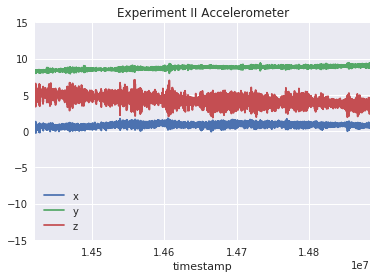

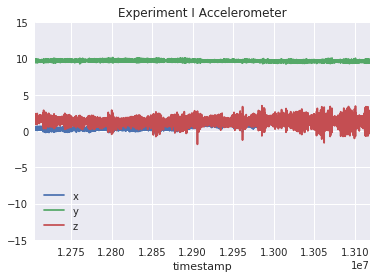

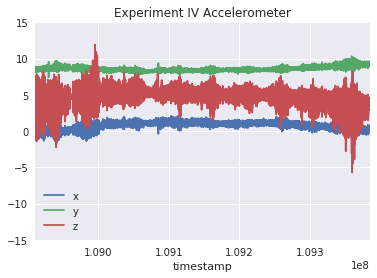

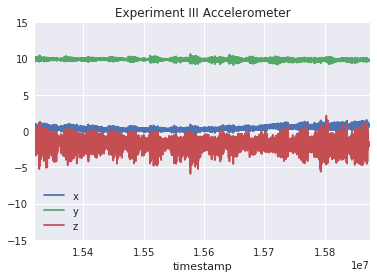

In [49]:
plotSensor(accData,'Accelerometer',[-15,15])

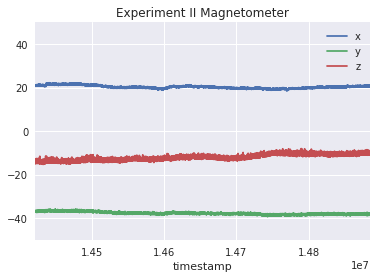

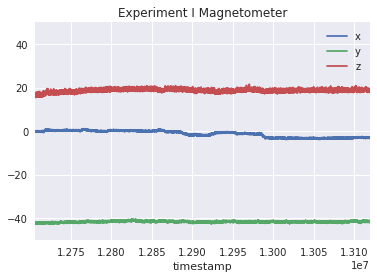

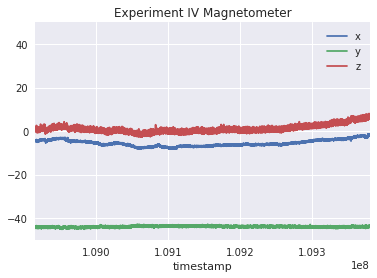

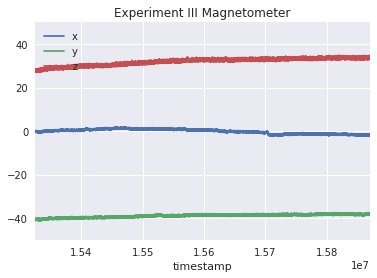

In [50]:
plotSensor(magData,'Magnetometer',[-50,50])

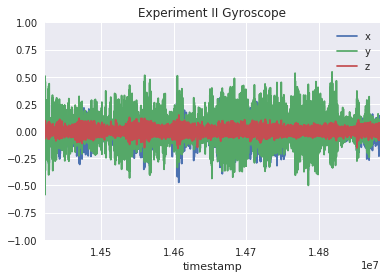

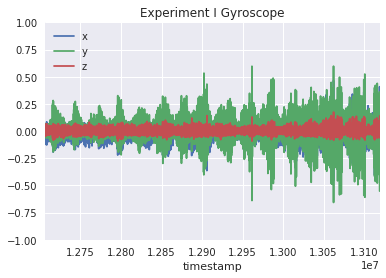

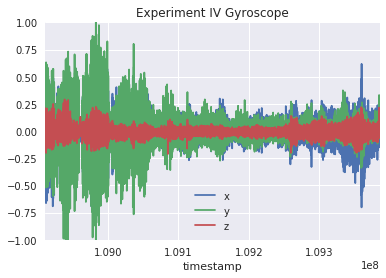

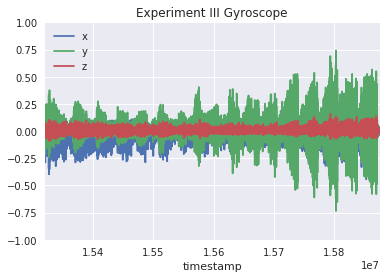

In [51]:
plotSensor(gyrData,'Gyroscope',[-1,1])

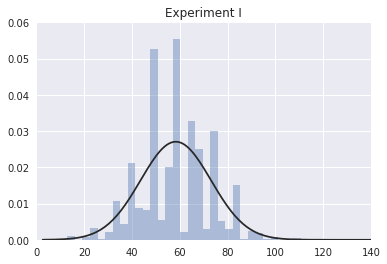

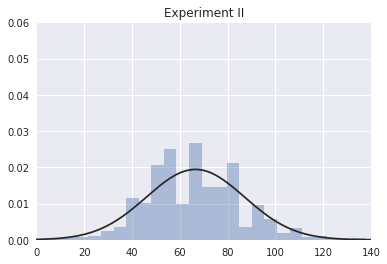

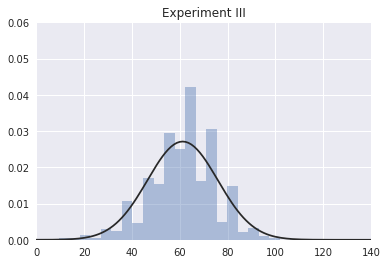

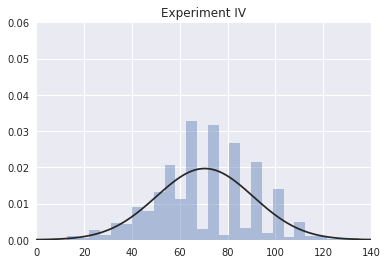

In [54]:
for key in tapData.keys():
    title='Experiment '+EXP_KEY[key]
    plotTapIntervalDist(tapData[key],title)
    plt.savefig('../Plots/Tap_Intervals/Experiment_'+title+'.png')
    plt.show()

/usr/lib64/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


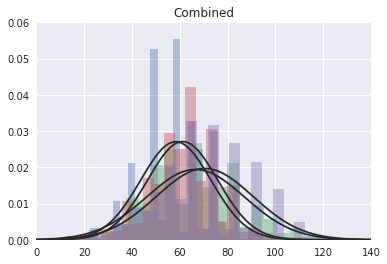

In [55]:
for key in tapData.keys():
    if key=='201711202025':
        continue
    plotTapIntervalDist(tapData[key],'Combined')
plt.savefig('../Plots/Tap_Intervals/AllExperiments.png')
plt.legend()
plt.show()

In [2]:
for key in tapData.keys():
    print key

NameError: name 'tapData' is not defined

In [53]:
from scipy.stats import norm
def plotTapIntervalDist(t,title):
    ax = sns.distplot((t.eventTime-t.downTime),fit=norm, kde=False)
    ax.set_xlim(0,140)
    ax.set_ylim(0,0.06)
    sns.plt.title(title)
def plotTapIntervalKDE(t,title):
    ax = sns.distplot((t.eventTime-t.downTime),hist=False, rug=True)
    sns.plt.title(title)
def plotTapButtonKDE(t, title):
    if(t.actionButton%9<3):
        ax = sns.kdeplot((t.eventTime-t.downTime), t.actionButton%9)
        sns.plt.title(title)

In [ ]:

for key in magData.keys():
    plt.plot(magData[key].index)
    plt.show()


In [ ]:
for key in gyrData.keys():
    plt.plot(gyrData[key].index)
    plt.show()

In [ ]:
for key in accData.keys():
    print(accData[key].index)
    #plt.show()

201711091951
201711092033
201711182141
201711161638
201711202025


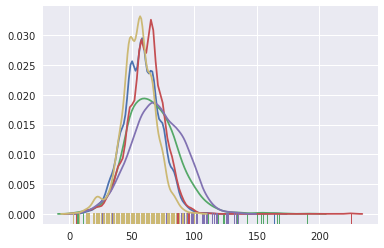

In [79]:
for key in tapData.keys():
    print(key)
    plotTapIntervalKDE(tapData[key])
plt.show()

201711091951


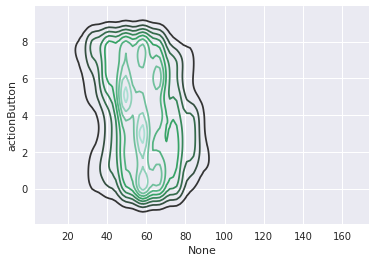

201711092033


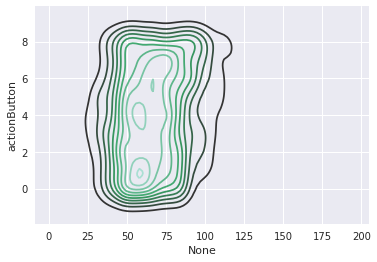

201711182141


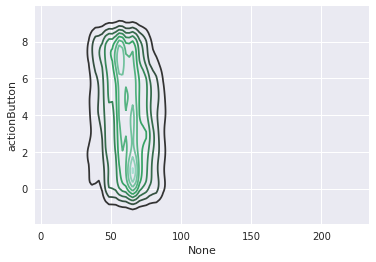

201711161638


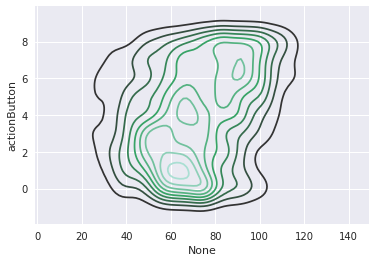

201711202025


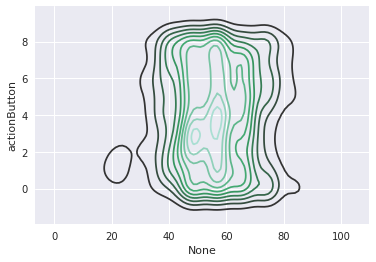

In [27]:
for key in tapData.keys():
    print(key)
    plotTapButtonKDE(tapData[key])
plt.show()

In [ ]:
for key in tapData.keys():
    print(key)
    plotTapButtonKDE(tapData[key])
plt.show()

201711091951
201711092033
201711182141
201711161638
201711202025


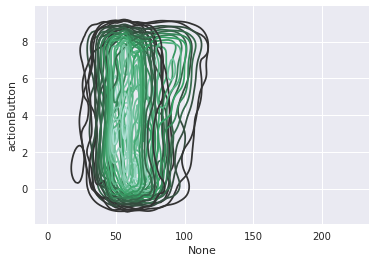

In [28]:
for key in tapData.keys():
    print(key)
    plotTapButtonKDE(tapData[key])
plt.show()